# Network Traffic Anomaly Detection

This notebook demonstrates how to detect anomalies in network traffic data using machine learning techniques. The project follows a structured workflow: data acquisition, preprocessing, feature engineering, unsupervised and supervised modeling, and evaluation.

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import requests
import os

## Phase 1: Data Acquisition

We will use the NSL-KDD dataset, a widely used benchmark for network intrusion detection. The dataset will be downloaded and loaded for analysis.

In [4]:
# Download the NSL-KDD dataset (KDDTrain+ and KDDTest+)
# Source: https://www.unb.ca/cic/datasets/nsl.html
train_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
test_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt"
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)
train_path = os.path.join(data_dir, "KDDTrain+.txt")
test_path = os.path.join(data_dir, "KDDTest+.txt")

for url, path in zip([train_url, test_url], [train_path, test_path]):
    if not os.path.exists(path):
        r = requests.get(url)
        with open(path, "wb") as f:
            f.write(r.content)
        print(f"Downloaded {path}")
    else:
        print(f"{path} already exists.")

data/KDDTrain+.txt already exists.
data/KDDTest+.txt already exists.


In [5]:
# Load the NSL-KDD dataset into pandas DataFrames
col_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty'
]
train_df = pd.read_csv(train_path, names=col_names)
test_df = pd.read_csv(test_path, names=col_names)
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
train_df.head()

Train shape: (125973, 43), Test shape: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## Phase 2: Data Preprocessing & Exploration

Now that the data is loaded, we will:
- Inspect the dataset for missing values and data types
- Clean and preprocess the data (handle missing values, encode categorical features, normalization)
- Perform exploratory data analysis (EDA) to understand feature distributions and correlations
- Visualize key statistics and patterns

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-n

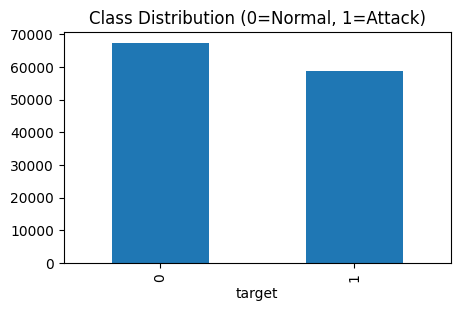

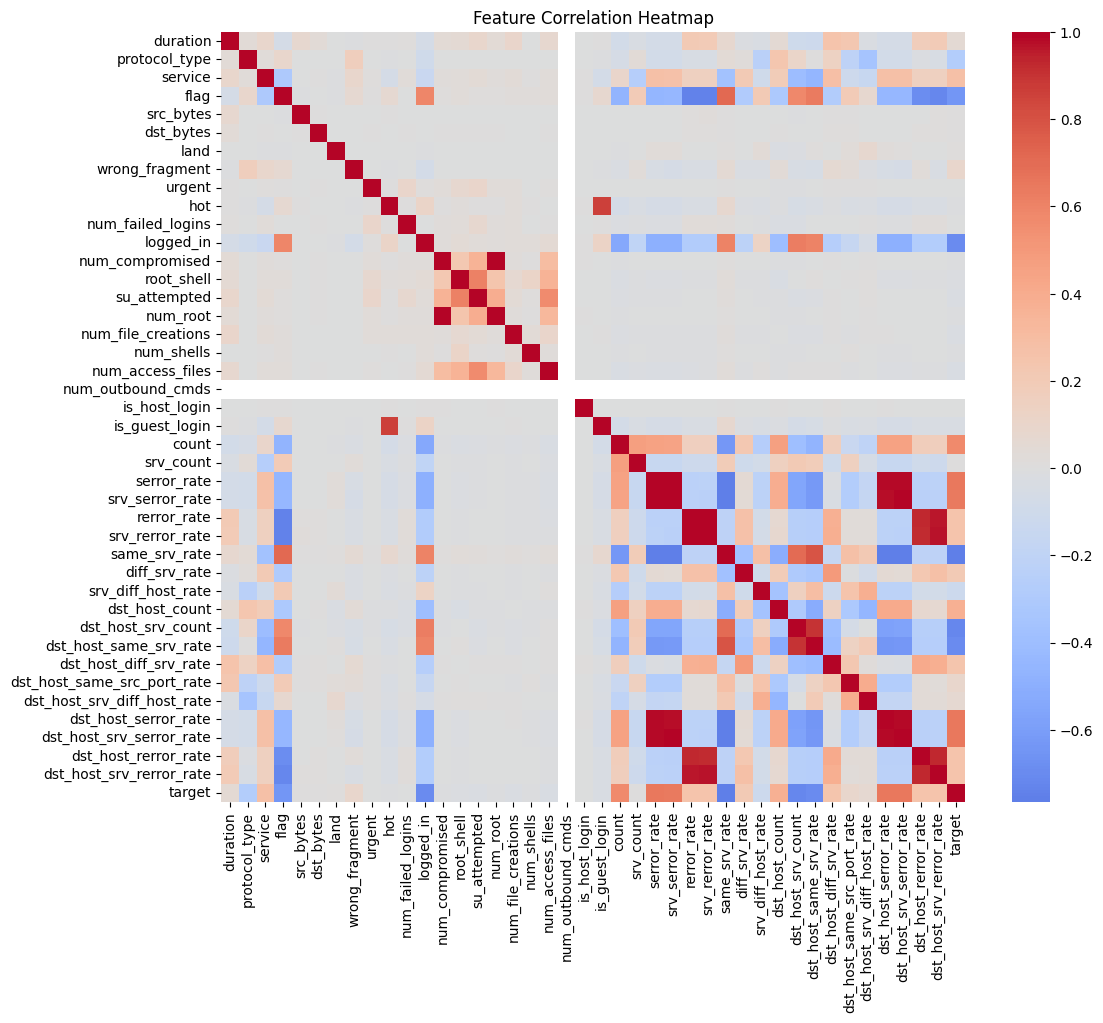

In [6]:
# Inspect for missing values and data types
print("Train Data Info:")
train_df.info()
print("\nTest Data Info:")
test_df.info()
print("\nMissing values in train:")
print(train_df.isnull().sum().sum())
print("Missing values in test:")
print(test_df.isnull().sum().sum())
"""
Encode categorical features: protocol_type, service, flag
Label encode the target variable (label)
"""
cat_cols = ['protocol_type', 'service', 'flag']
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
# Encode target variable: normal=0, attack=1
train_df['target'] = (train_df['label'] != 'normal').astype(int)
test_df['target'] = (test_df['label'] != 'normal').astype(int)
print(train_df[['label', 'target']].head())
"""
Drop columns not needed for modeling (e.g., 'difficulty', 'label')
"""
drop_cols = ['difficulty', 'label']
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)
print(f"Train columns: {train_df.columns.tolist()}")
"""
Normalize numerical features
"""
num_cols = train_df.select_dtypes(include=[np.number]).columns.drop('target')
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])
print(train_df[num_cols].describe().T.head())
"""
Exploratory Data Analysis (EDA):
- Class distribution
- Correlation heatmap
- Feature distributions
"""
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,3))
train_df['target'].value_counts().plot(kind='bar', title='Class Distribution (0=Normal, 1=Attack)')
plt.show()
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

## Phase 3: Feature Engineering

In this phase, we will:
- Select relevant features for anomaly detection
- Optionally create new features
- Apply dimensionality reduction (PCA) for visualization and improved modeling

Dropping highly correlated features: ['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate']
Added bytes_ratio feature.


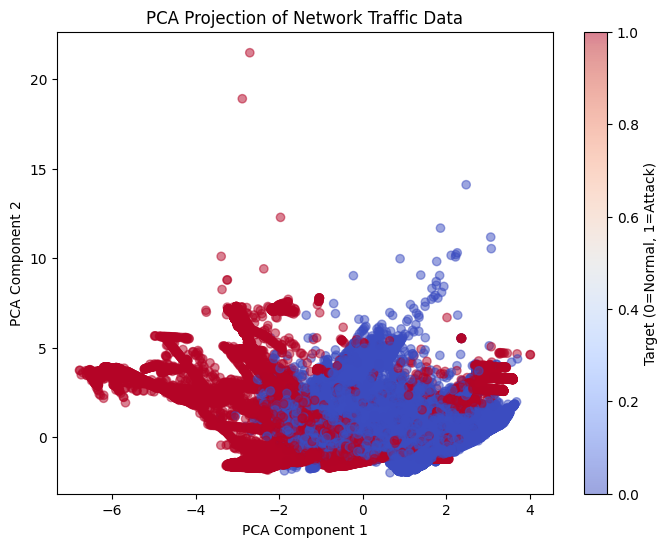

In [7]:
# Feature Selection: Remove highly correlated features (optional)
# Calculate correlation matrix and drop features with correlation > 0.95
corr_matrix = train_df.drop('target', axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Dropping highly correlated features: {to_drop}")
train_df_reduced = train_df.drop(columns=to_drop)
test_df_reduced = test_df.drop(columns=to_drop)

# Optionally, create new features (example: src_bytes to dst_bytes ratio)
if 'src_bytes' in train_df_reduced.columns and 'dst_bytes' in train_df_reduced.columns:
    train_df_reduced['bytes_ratio'] = train_df_reduced['src_bytes'] / (train_df_reduced['dst_bytes'] + 1)
    test_df_reduced['bytes_ratio'] = test_df_reduced['src_bytes'] / (test_df_reduced['dst_bytes'] + 1)
    print("Added bytes_ratio feature.")

# Dimensionality Reduction with PCA for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(train_df_reduced.drop('target', axis=1))
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=train_df_reduced['target'], cmap='coolwarm', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Network Traffic Data')
plt.colorbar(label='Target (0=Normal, 1=Attack)')
plt.show()

## Phase 4: Unsupervised Anomaly Detection

In this phase, we will:
- Apply unsupervised algorithms (Isolation Forest, DBSCAN)
- Visualize detected anomalies
- Evaluate results using available labels

In [9]:
# For faster experimentation, sample a subset of the data
sample_frac = 0.2  # Use 20% of the data
train_sample = train_df_reduced.sample(frac=sample_frac, random_state=42)
X_sample = train_sample.drop('target', axis=1)
y_sample = train_sample['target']

# Recompute PCA for the sample
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca_sample = pca.fit_transform(X_sample)

Isolation Forest classification report (sample):
              precision    recall  f1-score   support

           0       0.58      0.86      0.69     13422
           1       0.64      0.27      0.38     11773

    accuracy                           0.59     25195
   macro avg       0.61      0.57      0.54     25195
weighted avg       0.60      0.59      0.55     25195



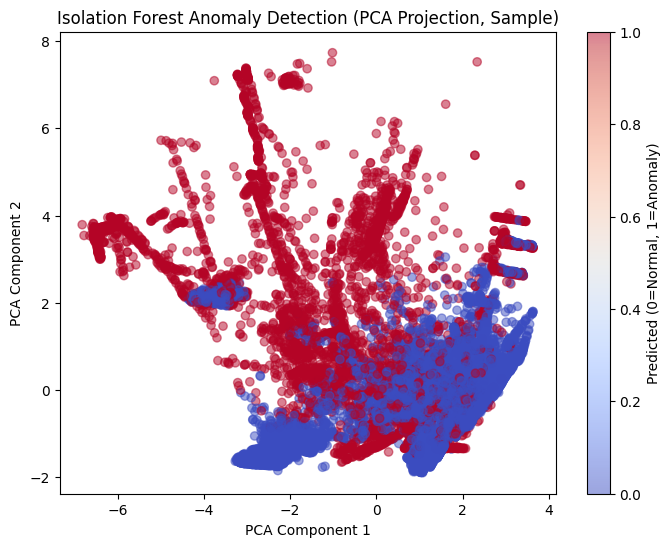

DBSCAN classification report (sample):
              precision    recall  f1-score   support

           0       0.53      0.98      0.69     13422
           1       0.31      0.01      0.02     11773

    accuracy                           0.53     25195
   macro avg       0.42      0.50      0.35     25195
weighted avg       0.43      0.53      0.38     25195



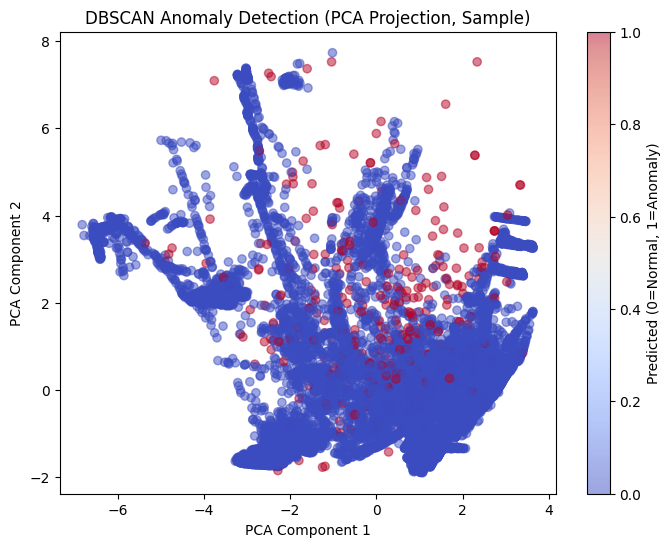

In [10]:
# Isolation Forest for anomaly detection (on sample)
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(n_estimators=50, contamination=0.2, n_jobs=1, random_state=42)
iso_preds = iso_forest.fit_predict(X_sample)
# Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
iso_preds = np.where(iso_preds == -1, 1, 0)
print("Isolation Forest classification report (sample):")
print(classification_report(y_sample, iso_preds))

# Visualize anomalies in PCA space (sample)
plt.figure(figsize=(8,6))
plt.scatter(X_pca_sample[:,0], X_pca_sample[:,1], c=iso_preds, cmap='coolwarm', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Isolation Forest Anomaly Detection (PCA Projection, Sample)')
plt.colorbar(label='Predicted (0=Normal, 1=Anomaly)')
plt.show()

# DBSCAN for anomaly detection (on sample)
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_sample)
# DBSCAN labels: -1 is anomaly, others are clusters
dbscan_anomaly = (dbscan_labels == -1).astype(int)
print("DBSCAN classification report (sample):")
print(classification_report(y_sample, dbscan_anomaly))

# Visualize DBSCAN anomalies in PCA space (sample)
plt.figure(figsize=(8,6))
plt.scatter(X_pca_sample[:,0], X_pca_sample[:,1], c=dbscan_anomaly, cmap='coolwarm', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Anomaly Detection (PCA Projection, Sample)')
plt.colorbar(label='Predicted (0=Normal, 1=Anomaly)')
plt.show()

## Phase 5: Supervised Classification

In this phase, we will:
- Train a supervised classification model (Random Forest)
- Evaluate the model using precision, recall, F1-score, and ROC-AUC
- Compare results with unsupervised methods

Random Forest classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13469
           1       1.00      1.00      1.00     11726

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



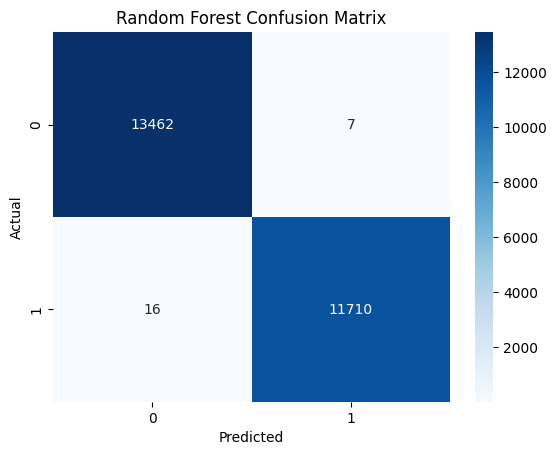

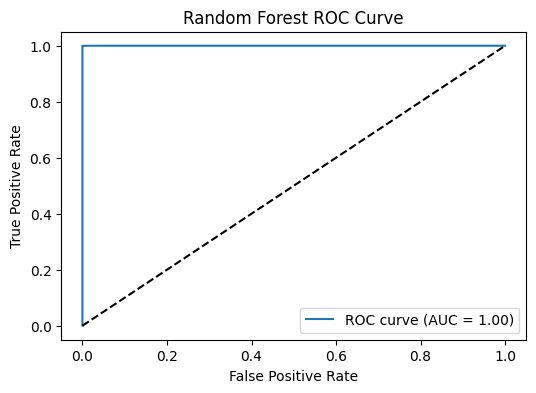

In [12]:
# Train/test split using the reduced feature set
y = train_df_reduced['target']
X = train_df_reduced.drop('target', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_val)
y_proba = rf.predict_proba(X_val)[:,1]
print("Random Forest classification report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# ROC-AUC
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_val, y_proba)
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.show()